In [41]:
#!/usr/bin/env python3
import numpy as np
import MDAnalysis as mda
from scipy.spatial import Delaunay, distance_matrix, Voronoi
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import random
from scipy.spatial import cKDTree

def bond_angle(xi, yi, xj, yj):
    dx = xj - xi
    dy = yj - yi
    return np.arctan2(dy,dx)

# --- Helper function: simple ring-finding based on DFS ---
def find_rings(adjacency, max_cycle_size=8):
    """
    Find all simple cycles (rings) in an undirected graph represented by an adjacency list.
    Returns a set of frozensets, each representing a ring (order is disregarded).
    """
    N = len(adjacency)
    found_rings = set()

    def dfs(start, current_path, visited_set):
        if len(current_path) > max_cycle_size:
            return
        current = current_path[-1]
        for nbr in adjacency[current]:
            if nbr == start and len(current_path) >= 3:
                # Found a cycle: sort the path to create a canonical representation
                ring = frozenset(current_path)
                found_rings.add(ring)
            elif nbr not in visited_set:
                dfs(start, current_path + [nbr], visited_set | {nbr})

    for i in range(N):
        dfs(i, [i], {i})
    return found_rings

# --- Helper function: reorder a ring into a cyclic path ---
def reorder_ring(ring_nodes, positions):
    """
    Given a set or list of nodes that form a cycle, return a list of nodes
    ordered such that consecutive nodes are (approximately) neighbors in space.
    A simple greedy approach is used.
    """
    ring_nodes = list(ring_nodes)
    if len(ring_nodes) < 3:
        return ring_nodes
    # Start with the leftmost node
    ring_nodes.sort(key=lambda i: (positions[i, 0], positions[i, 1]))
    ordered = [ring_nodes[0]]
    used = set(ordered)
    while len(ordered) < len(ring_nodes):
        last = ordered[-1]
        # Choose the remaining node closest to the last one.
        next_node = min([i for i in ring_nodes if i not in used],
                        key=lambda i: np.linalg.norm(positions[i]-positions[last]))
        ordered.append(next_node)
        used.add(next_node)
    return ordered
def plot_lattice(positions, random_atom, random_index, neighbor_list, neighbor_indices, zoom, atom_numbers,title="crystal"):
    N = len(positions)
    neighbor_count = np.array([len(nlist) if isinstance(nlist, list) else 1 for nlist in neighbor_list])

    color_array = []
    for i in range(N):
        if neighbor_count[i] == 5:
            color_array.append('red')       # potential pentagon site
        elif neighbor_count[i] == 6:
            color_array.append('gray')      # typical hexagon site
        elif neighbor_count[i] == 7:
            color_array.append('red')       # potential heptagon site
        else:
            color_array.append('lightgray')
    
    edges = []
    for i in range(N):
        neighs = neighbor_list[i] if isinstance(neighbor_list[i], list) else [neighbor_list[i]]
        for j in neighs:
            if j > i:
                edges.append((i, j))
    
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.set_title(title)
    
    pos_x = positions[:, 0]
    pos_y = positions[:, 1]
    ax.scatter(pos_x, pos_y, c=color_array, s=30, label='Atoms')
    
    if zoom == True:
        for (i, j) in edges:
            xi, yi = positions[i]
            xj, yj = positions[j]
            ax.plot([xi, xj], [yi, yj], 'k-', linewidth=0.5, alpha=0.7)
        
        pos_x = positions[:, 0]
        pos_y = positions[:, 1]
        ax.scatter(pos_x, pos_y, c=color_array, s=30, label='Atoms')

        ax.scatter(random_atom[0], random_atom[1], color='red', s=100,
                label=f'Atom {atom_numbers[random_index]} (Chosen)')
        if neighbor_indices:
            ax.scatter(positions[neighbor_indices, 0], positions[neighbor_indices, 1],
                    color='blue', s=60, label='Nearest Neighbors')
        
        ax.text(random_atom[0], random_atom[1], f'{atom_numbers[random_index]}',
                color='red', fontsize=12, ha='right', va='top')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True)
    ax.axis('equal')

    rings = find_rings(neighbor_list, max_cycle_size=8)
    # Loop over each ring
    for ring in rings:
        ring_size = len(ring)
        
        # Reorder ring nodes to make a continuous polygon
        ordered_ring = reorder_ring(ring, positions)
        
        # Choose color: red for 5 and 7, gray for 6.
        if ring_size == 6:
            ring_color = 'green'
        else:
            ring_color = 'red'
        
        # Draw the ring boundary (closed polygon)
        ring_coords = positions[ordered_ring]
        # Append the first coordinate at the end to close the loop
        ring_coords = np.vstack([ring_coords, ring_coords[0]])
        ax.plot(ring_coords[:,0], ring_coords[:,1], '-', color=ring_color, linewidth=2)
    
    # 6) Inset for zoomed-in bond-angle view for the chosen atom and its neighbors.
    inset_size = 0.35
    if zoom == True:
        axins = inset_axes(ax, width=f"{int(inset_size*100)}%", height=f"{int(inset_size*100)}%",
                        loc='upper right', borderpad=2)

        # In the inset, plot the background (all atoms as light gray)
        axins.scatter(pos_x, pos_y, c='black', s=10)
        axins.scatter(random_atom[0], random_atom[1], color='red', s=100)
        axins.scatter(positions[neighbor_indices, 0], positions[neighbor_indices, 1],
                    color='blue', s=60)

        # Draw green dashed lines from the chosen atom to each neighbor in inset
        angles = []
        for j in neighbor_indices:
            xj, yj = positions[j]
            theta = bond_angle(random_atom[0], random_atom[1], xj, yj)
            angles.append(theta)
            
            axins.plot([random_atom[0], xj], [random_atom[1], yj], 'g--', linewidth=1)
            angle_deg = np.degrees(theta)
            mid_x = (random_atom[0] + xj) / 2
            mid_y = (random_atom[1] + yj) / 2
            axins.text(mid_x, mid_y, f"{angle_deg:.1f}°", fontsize=8,
                    color='black', ha='center', va='center')
        
        padding = 2.0
        axins.set_xlim(random_atom[0] - padding, random_atom[0] + padding)
        axins.set_ylim(random_atom[1] - padding, random_atom[1] + padding)
        axins.set_xticks([])
        axins.set_yticks([])
        axins.set_title(r"Director field $\theta_{ij}$", fontsize=12)
    
    plt.show()

In [ ]:
import numpy as np
from scipy.spatial import cKDTree

def read_positions_file(filename):
    frames, frame = [], []
    with open(filename, 'r') as f:
        for line in f:
            s = line.strip()
            # Start a new frame on header or blank
            if not s or s.startswith('#'):
                if frame:
                    frames.append(np.array(frame))
                    frame = []
                continue
            parts = s.split()
            if len(parts) < 3:
                continue
            x = float(parts[1])
            y = float(parts[2])
            frame.append([x, y])
    if frame:
        frames.append(np.array(frame))
    return frames


def build_neighbor_list(positions, box, k):
    N = positions.shape[0]
    Lx, Ly = box
    # Generate 9-image periodic tiling
    shifts = np.array([(dx, dy) for dx in (-Lx, 0, Lx) for dy in (-Ly, 0, Ly)])
    tiled_positions = np.vstack([positions + shift for shift in shifts])
    # Build KD-tree
    tree = cKDTree(tiled_positions)
    # Query k+1 to include self (distance zero)
    dist, idx = tree.query(positions, k=k+1)
    # Remove self matches and wrap indices back to [0,N)
    neighbors = idx[:, 1:] % N
    distances = dist[:, 1:]
    return neighbors, distances

positions_file = 'output\positions_0_K.txt'  # path to your multi-frame positions file
box = (34.43317, 34.08)                # simulation box dimensions (Lx, Ly)
k = 6                             # number of neighbors per atom

# Read all frames
frames = read_positions_file(positions_file)
F = len(frames)
N = frames[0].shape[0]
nbrs = np.empty((F, N, k), dtype=int)
distances_all = np.empty((F, N, k), dtype=float)

# Compute neighbor lists for each frame
for i, pos in enumerate(frames):
    nb, ds = build_neighbor_list(pos, box, k)
    nbrs[i] = nb
    distances_all[i] = ds

print(f"Computed {k} neighbors for {N} atoms over {F} frames.")
np.savez('neighbors.npz', neighbors=nbrs, distances=distances_all)

<>:62: SyntaxWarning: invalid escape sequence '\p'
<>:62: SyntaxWarning: invalid escape sequence '\p'
C:\Users\David\AppData\Local\Temp\ipykernel_12976\922811707.py:62: SyntaxWarning: invalid escape sequence '\p'
  positions_file = 'output\positions_0_K.txt'  # path to your multi-frame positions file


Computed 6 neighbors for 448 atoms over 516 frames.


In [ ]:
def compute_psi6(frames, nbrs, box):
    F = len(frames)
    N, k = nbrs.shape[1:]
    Lx, Ly = box
    dx = pos[nbrs,0] - pos[:,0,None]    # shape (N,k)
    dy = pos[nbrs,1] - pos[:,1,None]    # shape (N,k)
    theta = np.arctan2(dy, dx)          
    theta = np.mod(theta, 2*np.pi)
    return 1/N * np.mean(np.exp(6 * 1j * theta))
    


def compute_G6(frames, psi6, box, bin_edges):
    F, N = psi6.shape
    Lx, Ly = box
    # collect all distances and weights
    dists = []
    weights = []
    iu, ju = np.triu_indices(N, k=1)
    for f in range(F):
        pos = frames[f]
        # compute pairwise dx,dy
        dx = pos[iu,0] - pos[ju,0]
        dy = pos[iu,1] - pos[ju,1]
        dx -= np.rint(dx/Lx)*Lx
        dy -= np.rint(dy/Ly)*Ly
        r = np.hypot(dx, dy)
        w = psi6[f, iu] * np.conj(psi6[f, ju])
        dists.append(r)
        weights.append(w)
    # concatenate over frames
    dists = np.concatenate(dists)
    weights = np.concatenate(weights)
    # histogram numerator and denominator
    num = np.histogram(dists, bins=bin_edges, weights=weights)[0]
    den = np.histogram(dists, bins=bin_edges)[0]
    # bin centers
    r_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    # avoid division by zero
    G6 = np.zeros_like(num, dtype=complex)
    mask = den>0
    G6[mask] = num[mask]/den[mask]
    return r_centers, G6

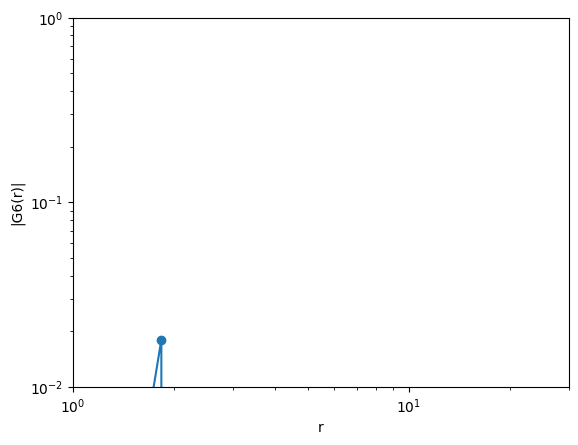

In [ ]:
#Load positions and neighbors:
frames = read_positions_file('output/positions_0_K.txt')
data = np.load('neighbors.npz')
nbrs = data['neighbors']
box = (34.43317, 34.08)

#Compute psi6 and G6:
psi6 = compute_psi6(frames, nbrs, box)
rmax = min(box)/2
bins = np.linspace(0, rmax, 80)
r, G6 = compute_G6(frames, psi6, box, bins)

#Plotting:
import matplotlib.pyplot as plt
plt.loglog(r, G6.real, 'o-')
plt.xlim((1,30))
plt.ylim((0.01,1))
plt.xlabel('r')
plt.ylabel('|G6(r)|')
plt.show()
